In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics # For F1 score

# 0. Pre-processing

In [2]:
protein_df = pd.read_csv('./fuzzy_macros_dataset_bmi.csv')
protein_df.head()

,BMI,BodyFat,Sex,Age,Protein_g,Calories_kcal,Fat_g,Carbohydrates_g
0,21.45,13.6,F,19,135.1,1801,60.0,180.1
1,23.53,8.8,M,57,161.2,2150,71.7,215.0
2,22.15,23.1,F,20,144.2,1923,64.1,192.3
3,23.61,11.9,M,32,189.7,2529,84.3,252.9
4,21.47,17.6,F,18,144.4,1925,64.2,192.5


In [3]:
protein_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BMI              95 non-null     float64
 1   BodyFat          95 non-null     float64
 2   Sex              95 non-null     object 
 3   Age              95 non-null     int64  
 4   Protein_g        95 non-null     float64
 5   Calories_kcal    95 non-null     int64  
 6   Fat_g            95 non-null     float64
 7   Carbohydrates_g  95 non-null     float64
dtypes: float64(5), int64(2), object(1)
memory usage: 6.1+ KB


In [4]:
protein_df.describe()

,BMI,BodyFat,Age,Protein_g,Calories_kcal,Fat_g,Carbohydrates_g
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,23.721579,18.813684,35.905263,162.116842,2161.578947,72.049474,216.157895
std,3.279800,7.392386,16.680396,22.646899,301.962291,10.063637,30.196229
min,17.640000,3.000000,18.000000,124.100000,1655.000000,55.200000,165.500000
25%,21.370000,13.750000,21.000000,144.500000,1926.500000,64.250000,192.650000
50%,23.400000,18.600000,32.000000,161.600000,2155.000000,71.800000,215.500000
75%,26.050000,23.950000,48.500000,177.800000,2370.500000,79.000000,237.050000
max,31.860000,34.700000,72.000000,212.000000,2827.000000,94.200000,282.700000


### Outlier Detection and Removal

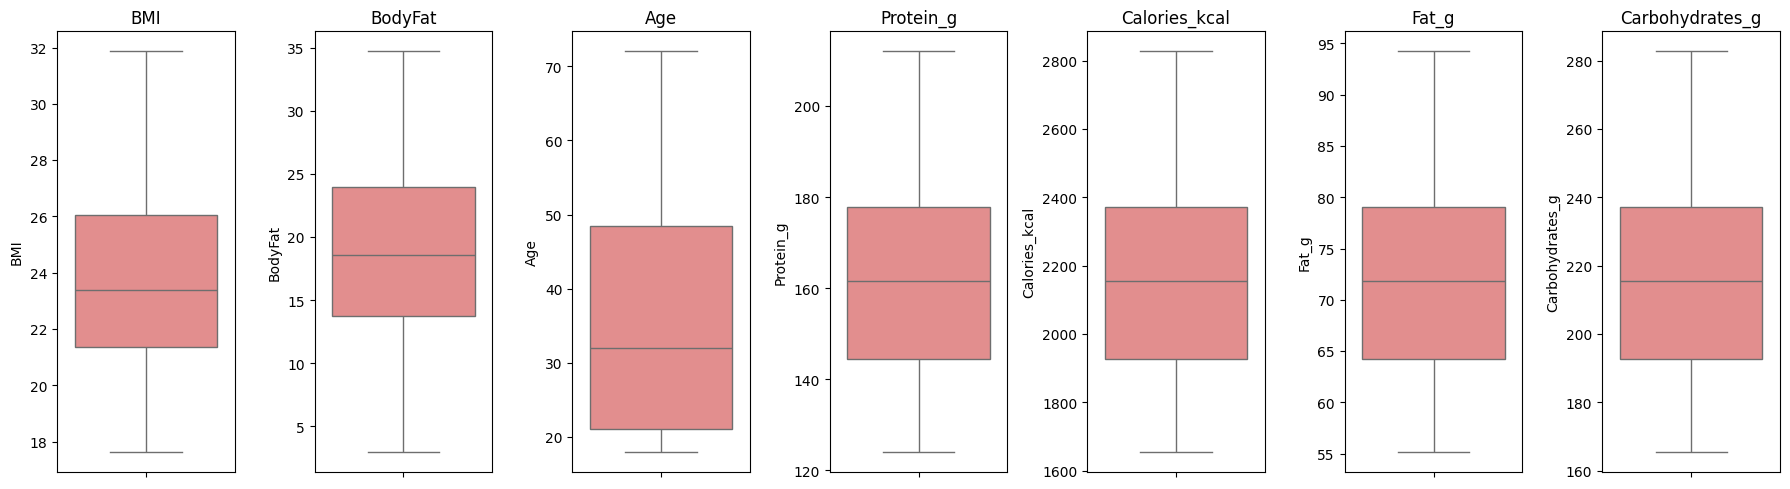

In [5]:
# visualisasi persebaran data menggunakan boxplot untuk mengidentifikasi outlier
numeric_columns_check = ['BMI', 'BodyFat', 'Age', 'Protein_g', 'Calories_kcal', 'Fat_g', 'Carbohydrates_g']
n_check = len(numeric_columns_check)

plt.figure(figsize=(18, 5))

for i, column in enumerate(numeric_columns_check): 
    plt.subplot(1, n_check, i+1)
    sns.boxplot(y=protein_df[column], color='lightcoral')
    plt.title(column)

plt.tight_layout()
plt.show()

Analisis grafik persebaran data dan anomali dalam dataset: 

1.  **BMI**: Median sekitar 24-25. Beberapa outliers tinggi di atas 35.
2.  **BodyFat**: Median sekitar 20-21%. Beberapa outliers tinggi di atas 35-40%.
3.  **Age**: Distribusi cukup merata dengan median sekitar 35-40 tahun. Beberapa outliers di usia sangat tua (>70).
4.  **Protein_g**: Median sekitar 150g. Distribusi tampak sedikit miring ke kanan dengan beberapa nilai tinggi.
5.  **Calories_kcal**: Median sekitar 2000 kcal. Ada beberapa outliers tinggi.
6.  **Fat_g**: Median sekitar 70g.
7.  **Carbohydrates_g**: Median sekitar 200g.

BMI: Dihapus 0 data outlier
BodyFat: Dihapus 0 data outlier
Age: Dihapus 0 data outlier
Protein_g: Dihapus 0 data outlier


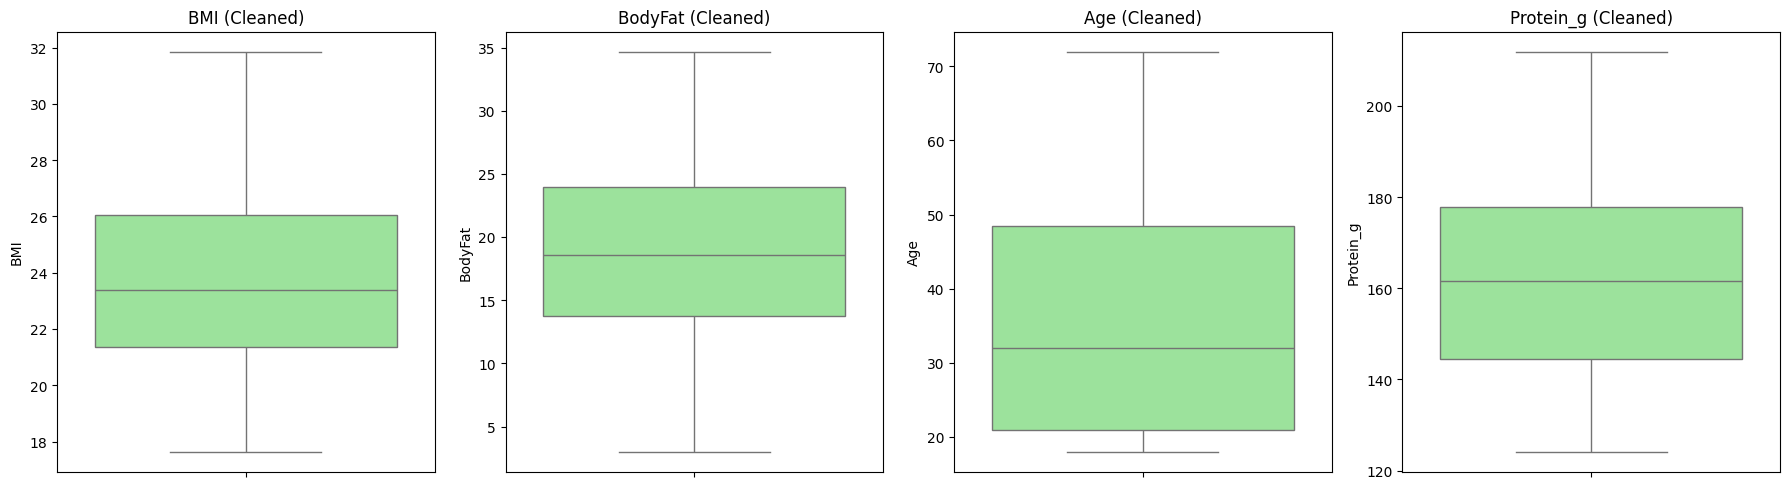

In [6]:
# Kolom yang relevan untuk fuzzy system (inputs + target)
relevant_columns_for_fuzzy = ['BMI', 'BodyFat', 'Age', 'Protein_g'] 

# Filter dan menghapus data dari outlier dengan metode IQR (Interquartile Range)
df_cleaned = protein_df.copy()
for column in relevant_columns_for_fuzzy:
    Q1 = df_cleaned[column].quantile(0.25)
    Q3 = df_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    before = df_cleaned.shape[0]
    df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    after = df_cleaned.shape[0]
    print(f"{column}: Dihapus {before - after} data outlier")

# Visualisasi persebaran data setelah menghapus outlier
plt.figure(figsize=(18, 5))
for i, column in enumerate(relevant_columns_for_fuzzy): 
    plt.subplot(1, len(relevant_columns_for_fuzzy), i+1)
    sns.boxplot(y=df_cleaned[column], color='lightgreen')
    plt.title(f'{column} (Cleaned)')

plt.tight_layout()
plt.show()

### Physiological Data Filtering
Berdasarkan `Fuzzy System Definition_Protein Intake.md`:
- Age universe: [18, 80]
- BMI universe: [15, 50]
- BodyFat Men universe: [2, 60]
- BodyFat Women universe: [10, 60]
- Protein_g universe: [50, 200]

Kita akan filter data untuk tetap berada dalam rentang yang masuk akal untuk MFs ini.

In [7]:
print(f"Data count before physiological filtering: {df_cleaned.shape[0]}")

# Age filter
df_cleaned = df_cleaned[(df_cleaned['Age'] >= 18) & (df_cleaned['Age'] <= 80)]

# BMI filter
df_cleaned = df_cleaned[(df_cleaned['BMI'] >= 15) & (df_cleaned['BMI'] <= 50)]

# BodyFat filter (gender-specific)
df_cleaned = df_cleaned[~((df_cleaned['Sex'] == 'M') & ((df_cleaned['BodyFat'] < 2) | (df_cleaned['BodyFat'] > 60)))]
df_cleaned = df_cleaned[~((df_cleaned['Sex'] == 'F') & ((df_cleaned['BodyFat'] < 10) | (df_cleaned['BodyFat'] > 60)))]

# Protein_g filter (target variable, for reasonable evaluation range)
df_cleaned = df_cleaned[(df_cleaned['Protein_g'] >= 30) & (df_cleaned['Protein_g'] <= 300)] # Wider than MF universe for flexibility

print(f"Data count after physiological filtering: {df_cleaned.shape[0]}")

Data count before physiological filtering: 95
Data count after physiological filtering: 94


# 1. Linguistic variables and Membership Functions (MFs)

### Helper functions for MFs

In [23]:
def trapmf(x, abcd):
    a, b, c, d = abcd
    if a > b: raise ValueError('a > b')
    if b > c: raise ValueError('b > c') # Allow b == c for triangular
    if c > d: raise ValueError('c > d')
        
    y = np.zeros_like(x if isinstance(x, np.ndarray) else [x])
    
    # Handle scalar input
    if not isinstance(x, np.ndarray):
        x = np.array([x])
        y = np.zeros_like(x, dtype=float)
        single_value = True
    else:
        y = np.zeros_like(x, dtype=float)
        single_value = False

    # Left slope
    if a != b:
        idx = np.logical_and(x >= a, x < b)
        y[idx] = (x[idx] - a) / (b - a)

    # Top part
    idx = np.logical_and(x >= b, x <= c)
    y[idx] = 1

    # Right slope
    if c != d:
        idx = np.logical_and(x > c, x <= d)
        y[idx] = (d - x[idx]) / (d - c)

    return y[0] if single_value else y
        
    return y[0] if isinstance(y, np.ndarray) and y.size == 1 else y

def trimf(x, abc):
    a, b, c = abc
    # Equivalent to trapmf(x, [a, b, b, c])
    return trapmf(x, [a, b, b, c])

### Input: BMI (kg/m²)

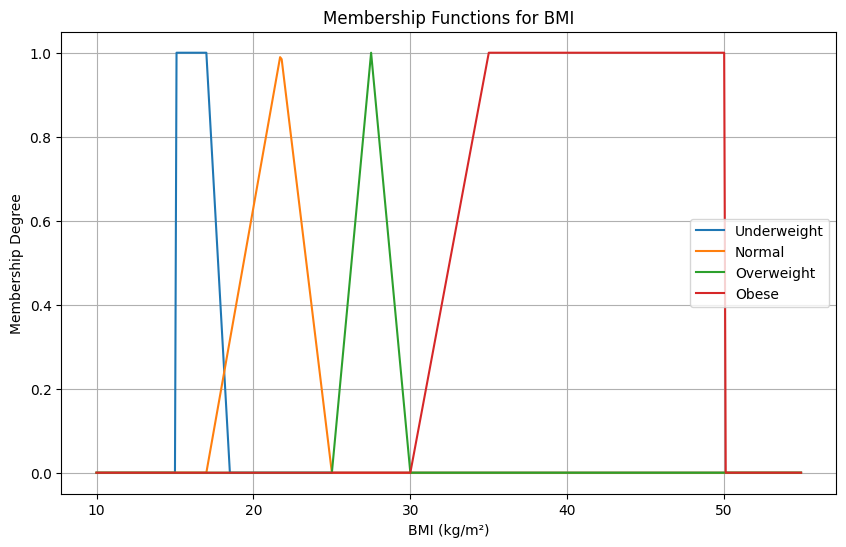

In [24]:
def bmi_underweight(bmi):
    return trapmf(bmi, [15, 15, 17, 18.5])

def bmi_normal(bmi):
    return trimf(bmi, [17, 21.75, 25])

def bmi_overweight(bmi):
    return trimf(bmi, [25, 27.5, 30])

def bmi_obese(bmi):
    return trapmf(bmi, [30, 35, 50, 50])

# Visualize BMI MFs
x_bmi = np.arange(10, 55, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(x_bmi, bmi_underweight(x_bmi), label='Underweight')
plt.plot(x_bmi, bmi_normal(x_bmi), label='Normal')
plt.plot(x_bmi, bmi_overweight(x_bmi), label='Overweight')
plt.plot(x_bmi, bmi_obese(x_bmi), label='Obese')
plt.title('Membership Functions for BMI')
plt.xlabel('BMI (kg/m²)')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

### Input: BodyFat % (Men)

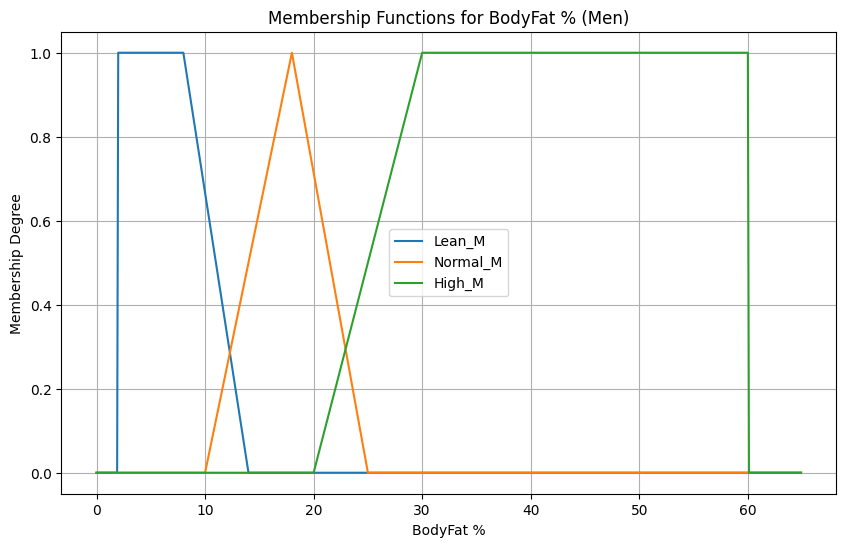

In [25]:
def bfm_lean(bodyfat):
    return trapmf(bodyfat, [2, 2, 8, 14])

def bfm_normal(bodyfat):
    return trimf(bodyfat, [10, 18, 25])

def bfm_high(bodyfat):
    return trapmf(bodyfat, [20, 30, 60, 60])

# Visualize BodyFat Men MFs
x_bf_m = np.arange(0, 65, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(x_bf_m, bfm_lean(x_bf_m), label='Lean_M')
plt.plot(x_bf_m, bfm_normal(x_bf_m), label='Normal_M')
plt.plot(x_bf_m, bfm_high(x_bf_m), label='High_M')
plt.title('Membership Functions for BodyFat % (Men)')
plt.xlabel('BodyFat %')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

### Input: BodyFat % (Women)

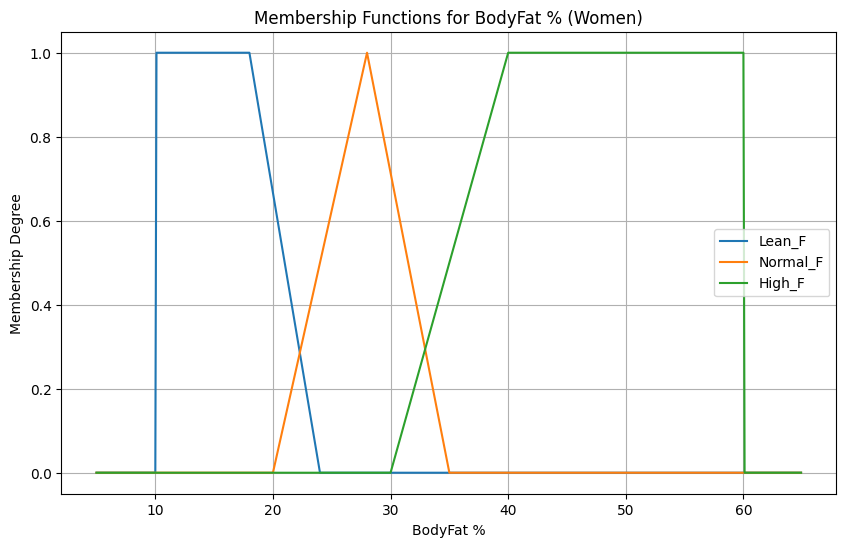

In [26]:
def bfw_lean(bodyfat):
    return trapmf(bodyfat, [10, 10, 18, 24])

def bfw_normal(bodyfat):
    return trimf(bodyfat, [20, 28, 35])

def bfw_high(bodyfat):
    return trapmf(bodyfat, [30, 40, 60, 60])

# Visualize BodyFat Women MFs
x_bf_f = np.arange(5, 65, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(x_bf_f, bfw_lean(x_bf_f), label='Lean_F')
plt.plot(x_bf_f, bfw_normal(x_bf_f), label='Normal_F')
plt.plot(x_bf_f, bfw_high(x_bf_f), label='High_F')
plt.title('Membership Functions for BodyFat % (Women)')
plt.xlabel('BodyFat %')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

### Input: Age (years)

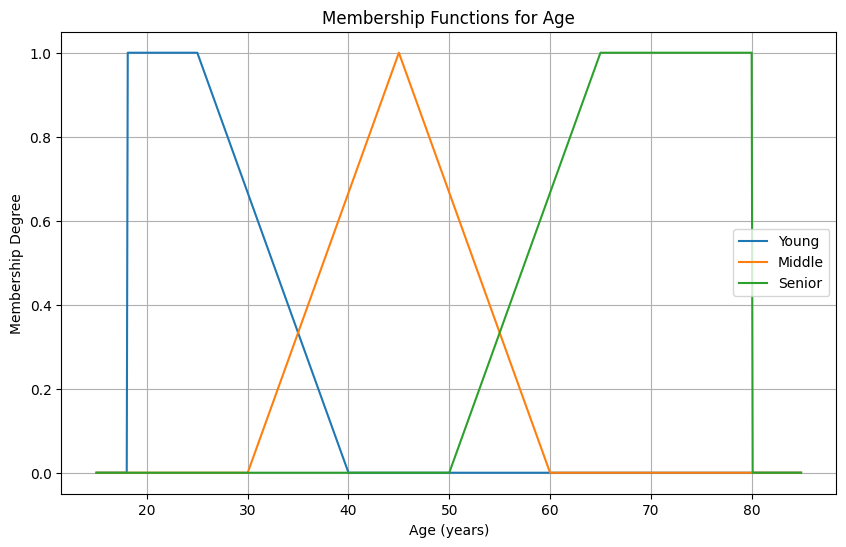

In [27]:
def age_young(age):
    return trapmf(age, [18, 18, 25, 40])

def age_middle(age):
    return trimf(age, [30, 45, 60])

def age_senior(age):
    return trapmf(age, [50, 65, 80, 80])

# Visualize Age MFs
x_age = np.arange(15, 85, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(x_age, age_young(x_age), label='Young')
plt.plot(x_age, age_middle(x_age), label='Middle')
plt.plot(x_age, age_senior(x_age), label='Senior')
plt.title('Membership Functions for Age')
plt.xlabel('Age (years)')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

### Output: Protein Intake (g)

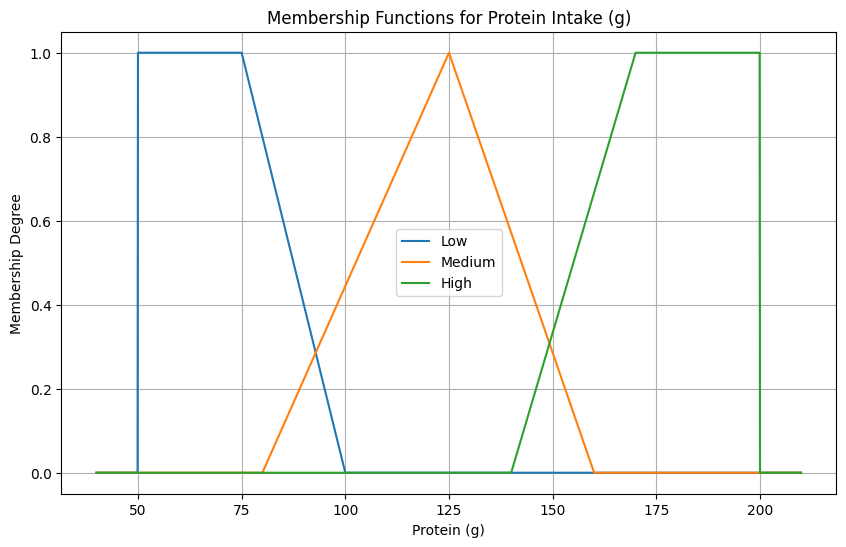

In [82]:
# Mamdani MFs
def protein_low_mf(protein):
    return trapmf(protein, [50, 50, 75, 100])

def protein_medium_mf(protein):
    return trimf(protein, [80, 125, 160])

def protein_high_mf(protein):
    return trapmf(protein, [140, 170, 200, 200])

# Sugeno Constants
protein_sugeno_constants = {
    'Low': 70,
    'Medium': 110,
    'High': 155
}

# Visualize Protein MFs (Mamdani)
x_protein = np.arange(40, 210, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(x_protein, protein_low_mf(x_protein), label='Low')
plt.plot(x_protein, protein_medium_mf(x_protein), label='Medium')
plt.plot(x_protein, protein_high_mf(x_protein), label='High')
plt.title('Membership Functions for Protein Intake (g)')
plt.xlabel('Protein (g)')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

# 2. Fuzzification

In [83]:
bmi_mf_terms = {
    'Underweight': bmi_underweight,
    'Normal': bmi_normal,
    'Overweight': bmi_overweight,
    'Obese': bmi_obese
}

bodyfat_m_mf_terms = { # Men
    'Lean_M': bfm_lean, 
    'Normal_M': bfm_normal, 
    'High_M': bfm_high
}

bodyfat_f_mf_terms = { # Women
    'Lean_F': bfw_lean, 
    'Normal_F': bfw_normal, 
    'High_F': bfw_high
}

age_mf_terms = {
    'Young': age_young,
    'Middle': age_middle,
    'Senior': age_senior
}

protein_output_mf_terms = {
    'Low': protein_low_mf,
    'Medium': protein_medium_mf,
    'High': protein_high_mf
}

In [84]:
def fuzzify_inputs(bmi, bodyfat, sex, age):
    fuzz_bmi = {term: mf(bmi) for term, mf in bmi_mf_terms.items()}
    
    if sex == 'M':
        fuzz_bf = {term: mf(bodyfat) for term, mf in bodyfat_m_mf_terms.items()}
    else: # sex == 'F'
        fuzz_bf = {term: mf(bodyfat) for term, mf in bodyfat_f_mf_terms.items()}
        
    fuzz_age = {term: mf(age) for term, mf in age_mf_terms.items()}
    
    return fuzz_bmi, fuzz_bf, fuzz_age

# Example fuzzification
example_bmi = 22
example_bf = 15
example_sex = 'M'
example_age = 30

f_bmi, f_bf, f_age = fuzzify_inputs(example_bmi, example_bf, example_sex, example_age)
print(f"Fuzzified BMI for {example_bmi}: {f_bmi}")
print(f"Fuzzified BodyFat ({example_sex}) for {example_bf}%: {f_bf}")
print(f"Fuzzified Age for {example_age} years: {f_age}")

Fuzzified BMI for 22: {'Underweight': np.float64(0.0), 'Normal': np.float64(0.9230769230769231), 'Overweight': np.float64(0.0), 'Obese': np.float64(0.0)}
Fuzzified BodyFat (M) for 15%: {'Lean_M': np.float64(0.0), 'Normal_M': np.float64(0.625), 'High_M': np.float64(0.0)}
Fuzzified Age for 30 years: {'Young': np.float64(0.6666666666666666), 'Middle': np.float64(0.0), 'Senior': np.float64(0.0)}


# 3. Inference Engine (Rule Evaluation)

In [85]:
# Rules as defined in Fuzzy System Definition_Protein Intake.md
# (Sex, BMI_Term, BodyFat_Term, Age_Term, Protein_Output_Term)
rules = [
    # Men
    ('M', 'Underweight', 'Lean_M', 'Young', 'Medium'),
    ('M', 'Underweight', 'Lean_M', 'Middle', 'Medium'),
    ('M', 'Underweight', 'Lean_M', 'Senior', 'Low'),
    ('M', 'Underweight', 'Normal_M', 'Young', 'Low'),
    ('M', 'Underweight', 'Normal_M', 'Middle', 'Low'),
    ('M', 'Underweight', 'Normal_M', 'Senior', 'Low'),
    ('M', 'Underweight', 'High_M', 'Young', 'Low'),
    ('M', 'Underweight', 'High_M', 'Middle', 'Low'),
    ('M', 'Underweight', 'High_M', 'Senior', 'Low'),
    ('M', 'Normal', 'Lean_M', 'Young', 'High'),
    ('M', 'Normal', 'Lean_M', 'Middle', 'High'),
    ('M', 'Normal', 'Lean_M', 'Senior', 'Low'),
    ('M', 'Normal', 'Normal_M', 'Young', 'High'),
    ('M', 'Normal', 'Normal_M', 'Middle', 'Medium'),
    ('M', 'Normal', 'Normal_M', 'Senior', 'Low'),
    ('M', 'Normal', 'High_M', 'Young', 'Low'),
    ('M', 'Normal', 'High_M', 'Middle', 'Low'),
    ('M', 'Normal', 'High_M', 'Senior', 'Low'),
    ('M', 'Overweight', 'Lean_M', 'Young', 'High'),
    ('M', 'Overweight', 'Lean_M', 'Middle', 'High'),
    ('M', 'Overweight', 'Lean_M', 'Senior', 'Low'),
    ('M', 'Overweight', 'Normal_M', 'Young', 'High'),
    ('M', 'Overweight', 'Normal_M', 'Middle', 'High'),
    ('M', 'Overweight', 'Normal_M', 'Senior', 'Low'),
    ('M', 'Overweight', 'High_M', 'Young', 'Low'),
    ('M', 'Overweight', 'High_M', 'Middle', 'Low'),
    ('M', 'Overweight', 'High_M', 'Senior', 'Low'),
    ('M', 'Obese', 'Lean_M', 'Young', 'Medium'),
    ('M', 'Obese', 'Lean_M', 'Middle', 'Low'),
    ('M', 'Obese', 'Lean_M', 'Senior', 'Low'),
    ('M', 'Obese', 'Normal_M', 'Young', 'Medium'),
    ('M', 'Obese', 'Normal_M', 'Middle', 'Low'),
    ('M', 'Obese', 'Normal_M', 'Senior', 'Low'),
    ('M', 'Obese', 'High_M', 'Young', 'Low'),
    ('M', 'Obese', 'High_M', 'Middle', 'Low'),
    ('M', 'Obese', 'High_M', 'Senior', 'Low'),
    # Women
    ('F', 'Underweight', 'Lean_F', 'Young', 'Medium'),
    ('F', 'Underweight', 'Lean_F', 'Middle', 'Medium'),
    ('F', 'Underweight', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Underweight', 'Normal_F', 'Young', 'Low'),
    ('F', 'Underweight', 'Normal_F', 'Middle', 'Low'),
    ('F', 'Underweight', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Underweight', 'High_F', 'Young', 'Low'),
    ('F', 'Underweight', 'High_F', 'Middle', 'Low'),
    ('F', 'Underweight', 'High_F', 'Senior', 'Low'),
    ('F', 'Normal', 'Lean_F', 'Young', 'High'),
    ('F', 'Normal', 'Lean_F', 'Middle', 'High'),
    ('F', 'Normal', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Normal', 'Normal_F', 'Young', 'High'),
    ('F', 'Normal', 'Normal_F', 'Middle', 'Medium'),
    ('F', 'Normal', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Normal', 'High_F', 'Young', 'Low'),
    ('F', 'Normal', 'High_F', 'Middle', 'Low'),
    ('F', 'Normal', 'High_F', 'Senior', 'Low'),
    ('F', 'Overweight', 'Lean_F', 'Young', 'High'),
    ('F', 'Overweight', 'Lean_F', 'Middle', 'High'),
    ('F', 'Overweight', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Overweight', 'Normal_F', 'Young', 'High'),
    ('F', 'Overweight', 'Normal_F', 'Middle', 'High'),
    ('F', 'Overweight', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Overweight', 'High_F', 'Young', 'Low'),
    ('F', 'Overweight', 'High_F', 'Middle', 'Low'),
    ('F', 'Overweight', 'High_F', 'Senior', 'Low'),
    ('F', 'Obese', 'Lean_F', 'Young', 'Medium'),
    ('F', 'Obese', 'Lean_F', 'Middle', 'Low'),
    ('F', 'Obese', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Obese', 'Normal_F', 'Young', 'Medium'),
    ('F', 'Obese', 'Normal_F', 'Middle', 'Low'),
    ('F', 'Obese', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Obese', 'High_F', 'Young', 'Low'),
    ('F', 'Obese', 'High_F', 'Middle', 'Low'),
    ('F', 'Obese', 'High_F', 'Senior', 'Low'),
]

In [86]:
def apply_rules(fuzz_bmi, fuzz_bf, fuzz_age, sex_input):
    """Applies fuzzy rules and returns aggregated output strengths for Mamdani 
       and list of (strength, consequent_value) for Sugeno."""
    
    aggregated_mamdani_strengths = {term: 0.0 for term in protein_output_mf_terms}
    sugeno_rule_outputs = [] # List to store (strength, sugeno_consequent_value)
    
    active_rules_details = []

    for rule_sex, bmi_term, bf_term, age_term, protein_consequent_term in rules:
        if rule_sex != sex_input:
            continue # Skip rule if sex doesn't match

        # Get membership degrees for antecedents
        bmi_strength = fuzz_bmi.get(bmi_term, 0)
        bf_strength = fuzz_bf.get(bf_term, 0) 
        age_strength = fuzz_age.get(age_term, 0)
        
        # AND operator (min for rule strength)
        rule_strength = min(bmi_strength, bf_strength, age_strength)
        
        if rule_strength > 0:
            active_rules_details.append({
                'BMI Term': bmi_term, 'BMI Strength': bmi_strength,
                'BF Term': bf_term, 'BF Strength': bf_strength,
                'Age Term': age_term, 'Age Strength': age_strength,
                'Protein Consequent': protein_consequent_term,
                'Rule Strength': rule_strength
            })
            
            # Mamdani: Aggregate using max for each output term
            aggregated_mamdani_strengths[protein_consequent_term] = max(
                aggregated_mamdani_strengths[protein_consequent_term], rule_strength
            )
            
            # Sugeno: Store strength and consequent constant
            sugeno_consequent_value = protein_sugeno_constants[protein_consequent_term]
            sugeno_rule_outputs.append((rule_strength, sugeno_consequent_value))
            
    return aggregated_mamdani_strengths, sugeno_rule_outputs, pd.DataFrame(active_rules_details)

In [87]:
# Example rule application
agg_mamdani, sug_outputs, active_rules_df = apply_rules(f_bmi, f_bf, f_age, example_sex)
print("Aggregated Mamdani Strengths:", agg_mamdani)
print("\nSugeno Rule Outputs (strength, consequent_value):", sug_outputs)
print("\nActive Rules Details:")
if not active_rules_df.empty:
    display(active_rules_df)
else:
    print("No rules activated for the given inputs.")

Aggregated Mamdani Strengths: {'Low': 0.0, 'Medium': 0.0, 'High': np.float64(0.625)}

Sugeno Rule Outputs (strength, consequent_value): [(np.float64(0.625), 155)]

Active Rules Details:


,BMI Term,BMI Strength,BF Term,BF Strength,Age Term,Age Strength,Protein Consequent,Rule Strength
0,Normal,0.923077,Normal_M,0.625,Young,0.666667,High,0.625


# 4. Defuzzification

### 4.1 Mamdani (Centroid)

In [88]:
protein_universe = np.arange(50, 201, 1) # Universe for protein output

def defuzzify_mamdani_centroid(aggregated_strengths, output_universe):
    numerator = 0
    denominator = 0
    
    aggregated_mf_values = np.zeros_like(output_universe, dtype=float)
    
    # Create the aggregated output membership function
    for protein_val_idx, protein_val in enumerate(output_universe):
        max_membership_for_protein_val = 0
        for protein_term, strength in aggregated_strengths.items():
            if strength > 0: # Only consider activated rules
                # Clip the original MF at the rule's strength
                clipped_value = min(protein_output_mf_terms[protein_term](protein_val), strength)
                # Aggregate (max) the clipped values for this point in the universe
                max_membership_for_protein_val = max(max_membership_for_protein_val, clipped_value)
        aggregated_mf_values[protein_val_idx] = max_membership_for_protein_val
        
        numerator += protein_val * max_membership_for_protein_val
        denominator += max_membership_for_protein_val
        
    if denominator == 0:
        return 0 # Or handle as an error/default value
        
    # Plotting the aggregated MF (optional)
    # plt.figure(figsize=(8,5))
    # plt.plot(output_universe, aggregated_mf_values, label='Aggregated Output MF')
    # plt.title('Aggregated Output Membership Function (Mamdani)')
    # plt.xlabel('Protein (g)')
    # plt.ylabel('Membership Degree')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    
    return numerator / denominator

In [89]:
# Example Mamdani defuzzification
mamdani_protein_prediction = defuzzify_mamdani_centroid(agg_mamdani, protein_universe)
print(f"Predicted Protein (Mamdani Centroid): {mamdani_protein_prediction:.2f}g")

Predicted Protein (Mamdani Centroid): 174.65g


### 4.2 Sugeno (Weighted Average)

In [90]:
def defuzzify_sugeno_weighted_average(sugeno_rule_outputs_list):
    numerator = 0
    denominator = 0
    
    if not sugeno_rule_outputs_list: # No rules fired
        return 0 
        
    for strength, consequent_value in sugeno_rule_outputs_list:
        numerator += strength * consequent_value
        denominator += strength
        
    if denominator == 0:
        return 0 # Or handle as an error/default value
        
    return numerator / denominator

In [91]:
# Example Sugeno defuzzification
sugeno_protein_prediction = defuzzify_sugeno_weighted_average(sug_outputs)
print(f"Predicted Protein (Sugeno Weighted Average): {sugeno_protein_prediction:.2f}g")

Predicted Protein (Sugeno Weighted Average): 155.00g


# 5. Evaluation

In [92]:
mamdani_predictions = []
sugeno_predictions = []
actual_protein_values = []

for index, row in df_cleaned.iterrows():
    bmi = row['BMI']
    bodyfat = row['BodyFat']
    sex = row['Sex']
    age = row['Age']
    actual_protein = row['Protein_g']
    
    f_bmi, f_bf, f_age = fuzzify_inputs(bmi, bodyfat, sex, age)
    agg_mamdani_strengths, sug_rule_outputs, _ = apply_rules(f_bmi, f_bf, f_age, sex)
    
    mamdani_pred = defuzzify_mamdani_centroid(agg_mamdani_strengths, protein_universe)
    sugeno_pred = defuzzify_sugeno_weighted_average(sug_rule_outputs)
    
    mamdani_predictions.append(mamdani_pred)
    sugeno_predictions.append(sugeno_pred)
    actual_protein_values.append(actual_protein)

df_cleaned['Protein_Mamdani_Predicted'] = mamdani_predictions
df_cleaned['Protein_Sugeno_Predicted'] = sugeno_predictions

In [93]:
# F1 Score Evaluation (requires binning)
protein_bins = [0, 102.5, 147.5, float('inf')] # Based on Sugeno constants midpoints
protein_labels = [0, 1, 2] # Low, Medium, High categories

actual_binned = pd.cut(df_cleaned['Protein_g'], bins=protein_bins, labels=protein_labels, include_lowest=True)
mamdani_binned = pd.cut(df_cleaned['Protein_Mamdani_Predicted'], bins=protein_bins, labels=protein_labels, include_lowest=True)
sugeno_binned = pd.cut(df_cleaned['Protein_Sugeno_Predicted'], bins=protein_bins, labels=protein_labels, include_lowest=True)

# Drop NA values that might result from binning if predictions are outside the universe
valid_indices_mamdani = actual_binned.notna() & mamdani_binned.notna()
valid_indices_sugeno = actual_binned.notna() & sugeno_binned.notna()

if valid_indices_mamdani.sum() > 0 and len(np.unique(actual_binned[valid_indices_mamdani])) > 1:
    f1_mamdani = metrics.f1_score(actual_binned[valid_indices_mamdani], mamdani_binned[valid_indices_mamdani], average='macro', zero_division=0)
    print(f"F1 Score (Mamdani - Binned): {f1_mamdani:.4f}")
else:
    print("Could not calculate Mamdani F1 score due to insufficient data after binning/NA removal or only one class present.")

if valid_indices_sugeno.sum() > 0 and len(np.unique(actual_binned[valid_indices_sugeno])) > 1:
    f1_sugeno = metrics.f1_score(actual_binned[valid_indices_sugeno], sugeno_binned[valid_indices_sugeno], average='macro', zero_division=0)
    print(f"F1 Score (Sugeno - Binned): {f1_sugeno:.4f}")
else:
    print("Could not calculate Sugeno F1 score due to insufficient data after binning/NA removal or only one class present.")

print("\n--- Sample of Actual vs Predicted Protein (with predictions) ---")
print(df_cleaned[['Protein_g', 'Protein_Mamdani_Predicted', 'Protein_Sugeno_Predicted']].head())

F1 Score (Mamdani - Binned): 0.2583
F1 Score (Sugeno - Binned): 0.2585

--- Sample of Actual vs Predicted Protein (with predictions) ---
   Protein_g  Protein_Mamdani_Predicted  Protein_Sugeno_Predicted
0      135.1                 176.568906                155.000000
1      161.2                 108.110552                 96.061321
2      144.2                 173.058014                155.000000
3      189.7                 155.354371                147.975610
4      144.4                 176.593389                155.000000


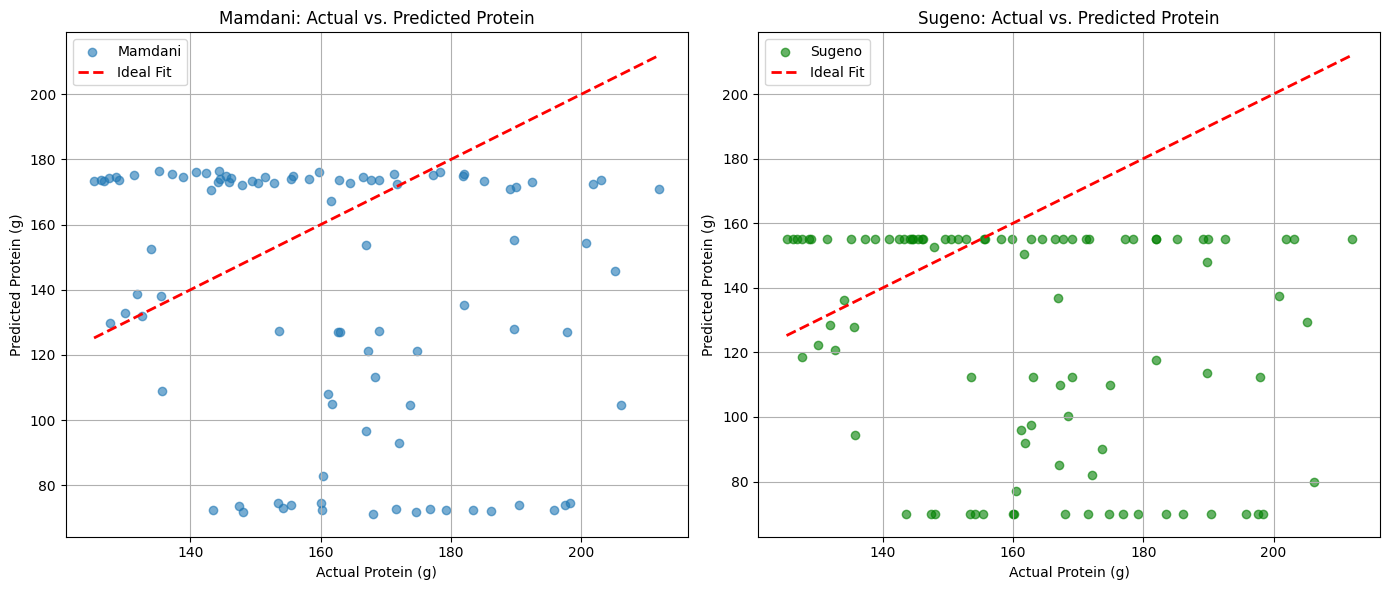

In [94]:
# Scatter plot of Actual vs. Predicted
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_cleaned['Protein_g'], df_cleaned['Protein_Mamdani_Predicted'], alpha=0.6, label='Mamdani')
plt.plot([df_cleaned['Protein_g'].min(), df_cleaned['Protein_g'].max()], 
         [df_cleaned['Protein_g'].min(), df_cleaned['Protein_g'].max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Protein (g)')
plt.ylabel('Predicted Protein (g)')
plt.title('Mamdani: Actual vs. Predicted Protein')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(df_cleaned['Protein_g'], df_cleaned['Protein_Sugeno_Predicted'], alpha=0.6, color='green', label='Sugeno')
plt.plot([df_cleaned['Protein_g'].min(), df_cleaned['Protein_g'].max()], 
         [df_cleaned['Protein_g'].min(), df_cleaned['Protein_g'].max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Protein (g)')
plt.ylabel('Predicted Protein (g)')
plt.title('Sugeno: Actual vs. Predicted Protein')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()